In [1]:
# Core
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# MSE imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import ast_elt_transform, plot_elt_transform_pdf, plot_elt_transform_map
from candidate_element import calc_beta, make_interp_x

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [3]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [4]:
# Set number of sample points
N_samp_u: int = 2**16
z_range: float = 6.0
N_samp_z: int = int(200*z_range + 1)

# Sample CDF levels: N_samp evenly spaced
cdf_samp_u = (np.arange(N_samp_u) + 0.5) / N_samp_u

# Sample CDF levels: z_samp points evenly spaced by Z
z_samp = np.linspace(-z_range, z_range, N_samp_z)
cdf_samp_z = norm.cdf(z_samp)
pdf_samp_z = norm.pdf(z_samp)

# Combine the two sets of sample points
cdf_samp = np.unique(np.hstack([cdf_samp_u, cdf_samp_z]))

In [5]:
# Review orbital elements
ast_elt

,Num,Name,epoch_mjd,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri
Num,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,58600.0,0.822197,0.237862,0.220677,5.066979,3.770460,0.503214,21.55,0.15,JPL 1,0.807024,272.309165,0.023074,-3.225717,-2.921908,-3.728932,-21.808984
1255501,1255501,2019 QL,58600.0,2.722045,0.530676,0.113833,4.741919,2.351059,5.297173,19.21,0.15,JPL 1,-2.082964,1640.368337,0.003830,-0.176219,-1.273172,0.809793,257.420824
1255502,1255502,2019 QQ,58600.0,1.053137,0.389091,0.172121,5.648270,2.028352,3.266522,25.31,0.15,JPL 1,-3.081905,394.753268,0.015917,-1.623227,-1.688469,1.393436,189.527723


## Build and Plot Transformed Orbital Elements

In [6]:
# Build transformed elements and interpolators
ast_elt_xf, interp_tbl = ast_elt_transform(ast_elt)

In [7]:
# Review orbital elements with extra transformed columns
ast_elt_xf

,Num,Name,a,e,inc,Omega,omega,f,epoch_mjd,log_a,...,cos_f,log_a_z,e_z,sin_inc_z,sin_Omega_z,cos_Omega_z,sin_omega_z,cos_omega_z,sin_f_z,cos_f_z
Num,,,,,,,,,,,,,,,,,,,,,
1,1,Ceres,2.769165,0.076009,0.184901,1.401596,1.284522,1.501306,58600.0,1.018546,...,0.069434,0.371682,-0.920343,0.481007,1.561032,0.136310,1.337657,0.227204,2.034043,0.290861
2,2,Pallas,2.772466,0.230337,0.608007,3.020817,5.411373,1.490912,58600.0,1.019737,...,0.079800,0.382073,1.066688,2.849431,-0.053389,-1.727551,-0.759020,0.586498,1.975070,0.299035
3,3,Juno,2.669150,0.256942,0.226699,2.964490,4.330836,0.996719,58600.0,0.981760,...,0.543060,0.080554,1.340379,0.811157,-0.004199,-1.540834,-1.164045,-0.312397,0.940136,0.691813
4,4,Vesta,2.361418,0.088721,0.124647,1.811840,2.630709,-4.436417,58600.0,0.859262,...,-0.272482,-0.791466,-0.715146,0.010545,1.374974,-0.162143,0.427263,-0.982996,1.388823,0.013821
5,5,Astraea,2.574249,0.191095,0.093672,2.470978,6.260280,-1.738676,58600.0,0.945558,...,-0.167092,-0.257131,0.591323,-0.347369,0.453227,-0.740831,-0.010034,2.448863,-1.623092,0.101835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,0.822197,0.237862,0.220677,5.066979,3.770460,0.807024,58600.0,-0.195775,...,0.691651,-3.391558,1.148620,0.761861,-1.393330,0.277830,-0.520644,-0.841008,0.730276,0.856645
1255501,1255501,2019 QL,2.722045,0.530676,0.113833,4.741919,2.351059,-2.082964,58600.0,1.001383,...,-0.490068,0.233559,2.445225,-0.099482,-2.464143,0.034561,0.687151,-0.670917,-0.995557,-0.188852
1255502,1255502,2019 QQ,1.053137,0.389091,0.172121,5.648270,2.028352,-3.081905,58600.0,0.051773,...,-0.998219,-2.821553,2.087920,0.375099,-0.717939,0.813327,1.060234,-0.376565,-0.038917,-1.949413


## Semimajor Axis, a

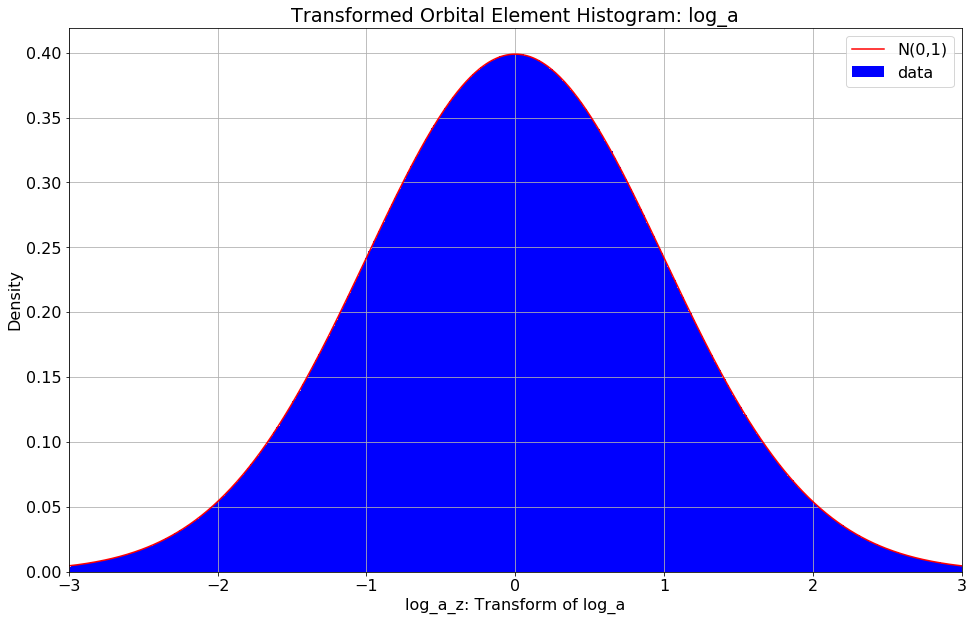

In [8]:
# Plot PDF of a
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='log_a')

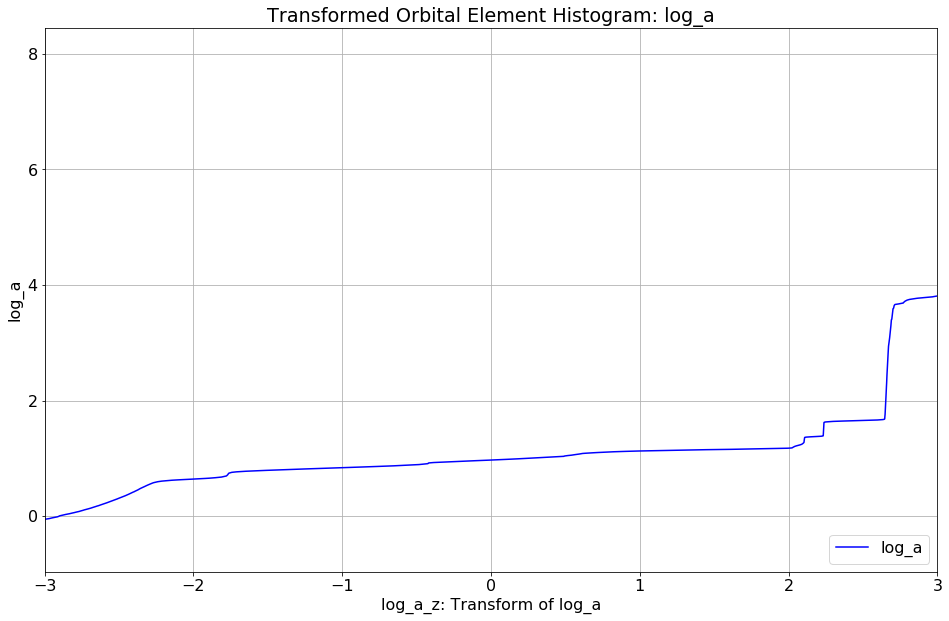

In [9]:
# Plot transform of a
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='log_a')

## Eccentricity, e

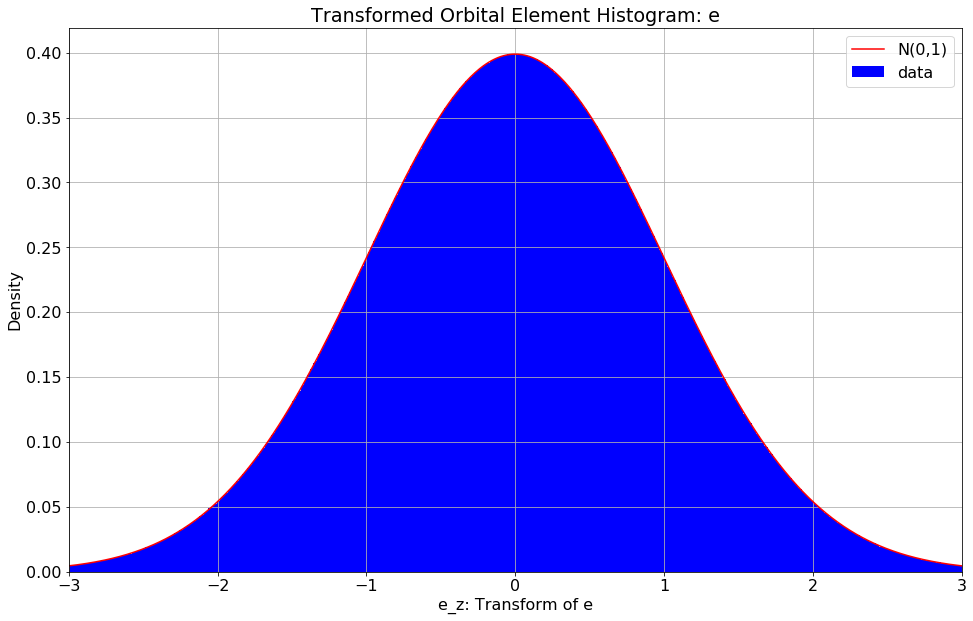

In [10]:
# Plot PDF of e
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='e')

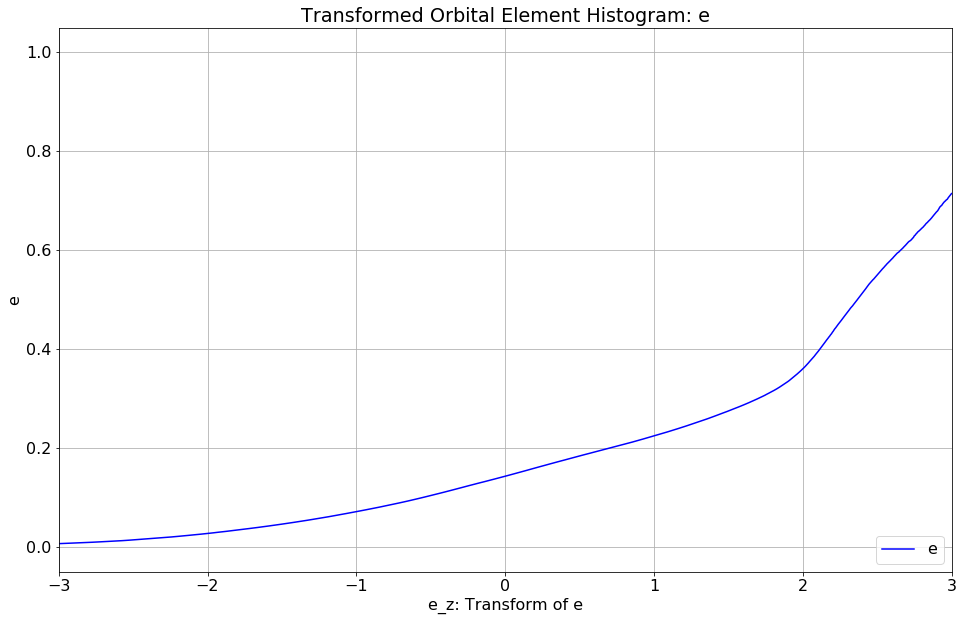

In [11]:
# Plot transform of e
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='e')

## Inclination, inc

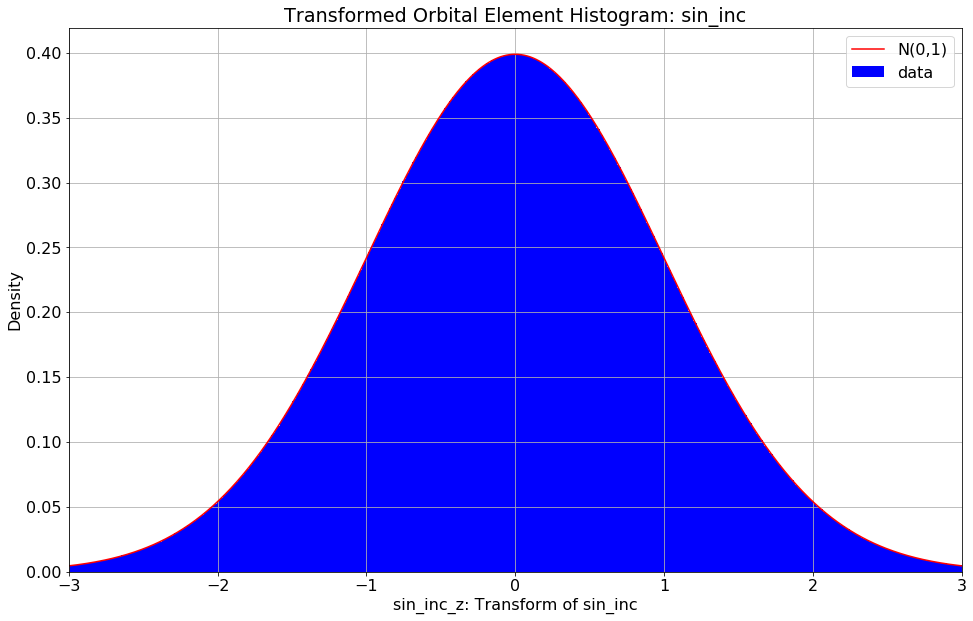

In [12]:
# Plot PDF of sin_inc
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_inc')

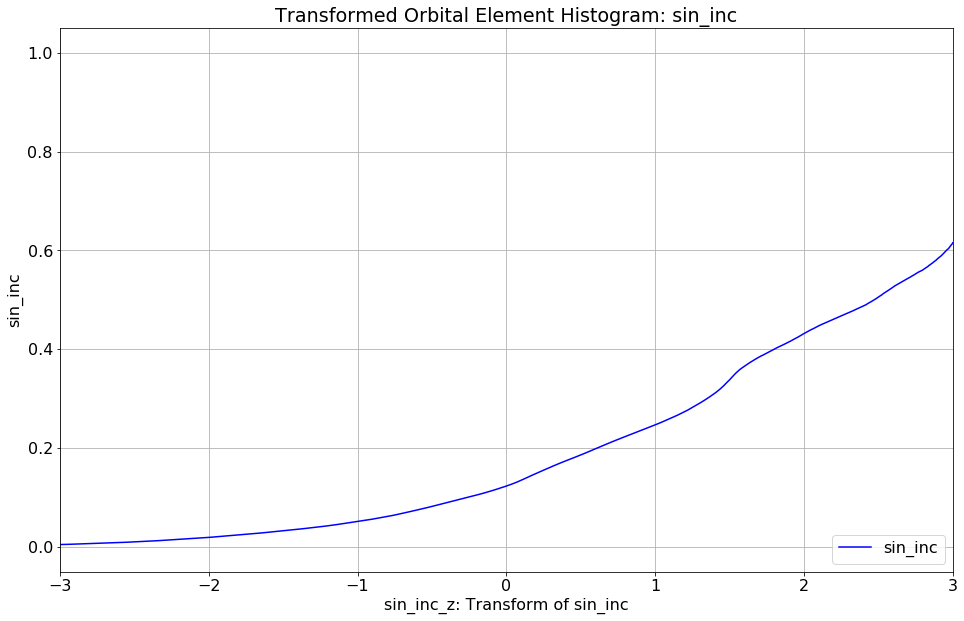

In [13]:
# Plot transform of sin_inc
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_inc')

## Omega

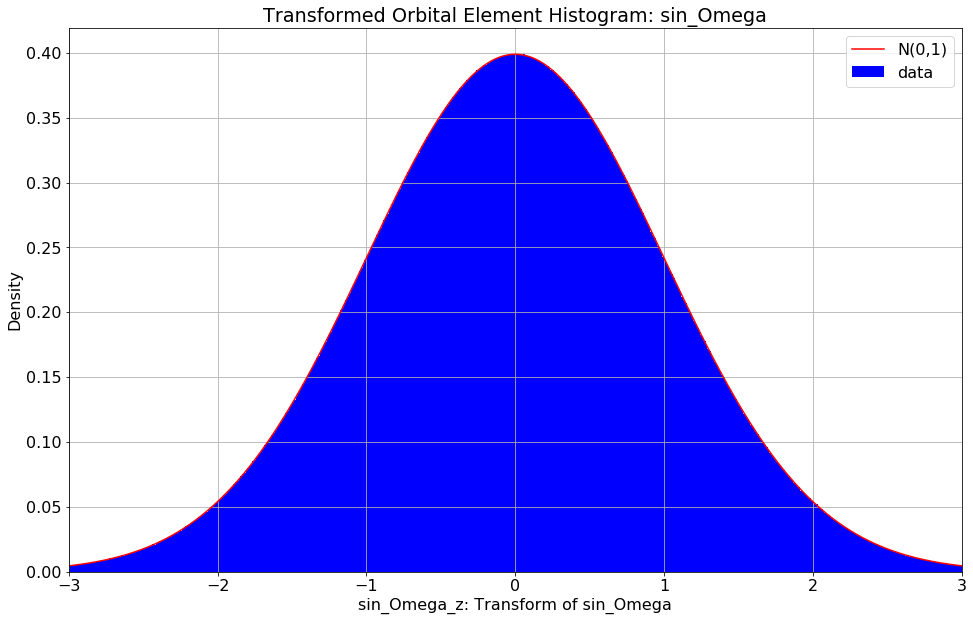

In [14]:
# Plot PDF of sin_Omega
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_Omega')

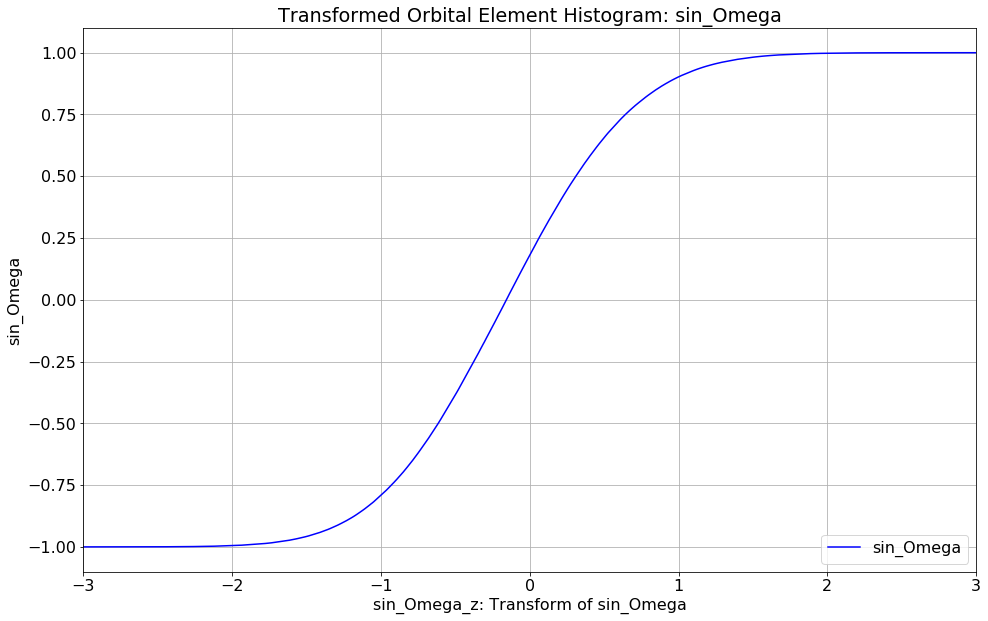

In [15]:
# Plot PDF of sin_Omega
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_Omega')

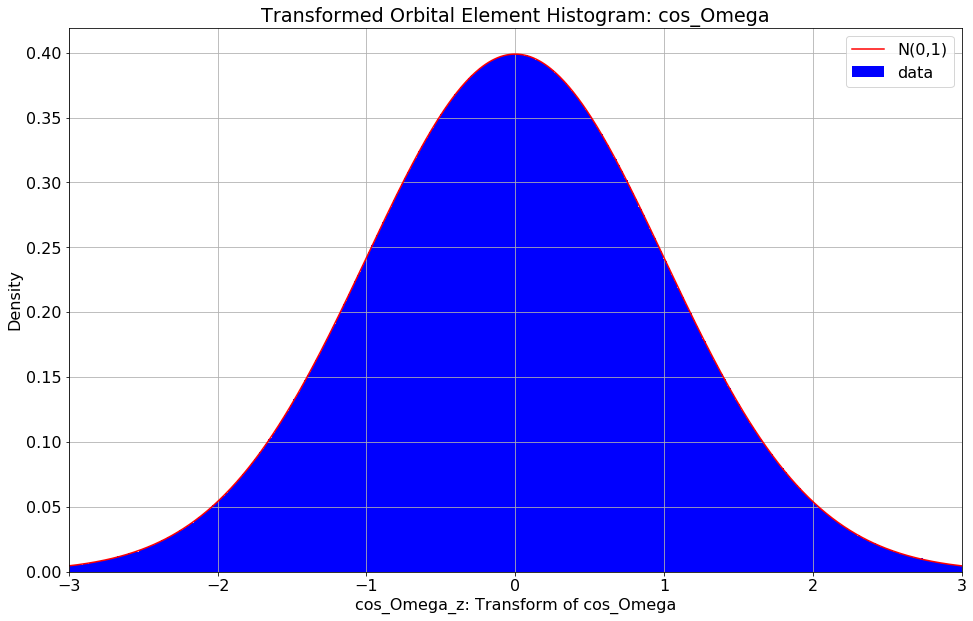

In [16]:
# Plot PDF of cos_Omega
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_Omega')

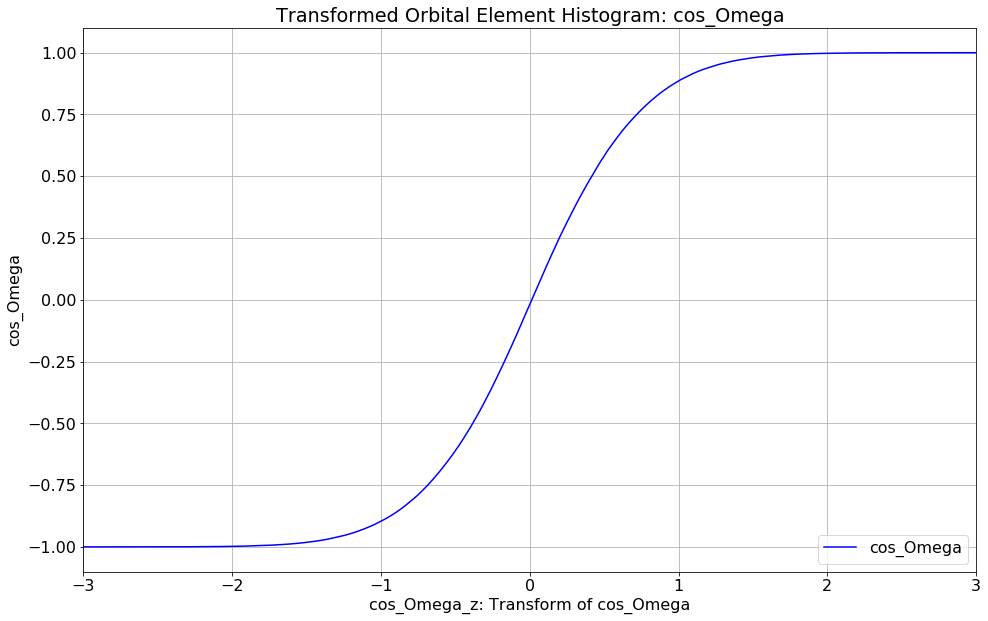

In [17]:
# Plot PDF of cos_Omega
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='cos_Omega')

## omega

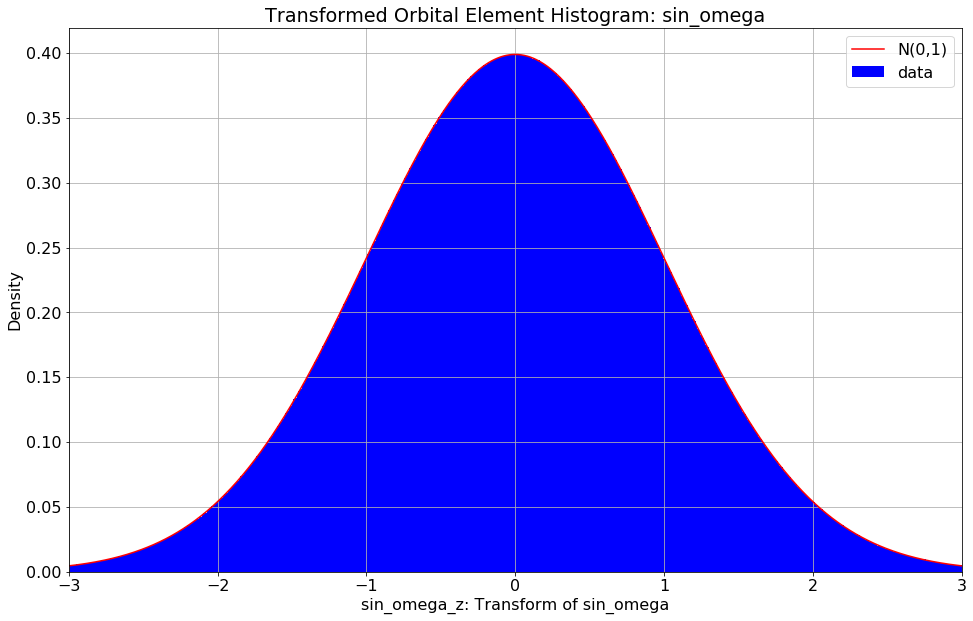

In [18]:
# Plot PDF of sin_omega
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_omega')

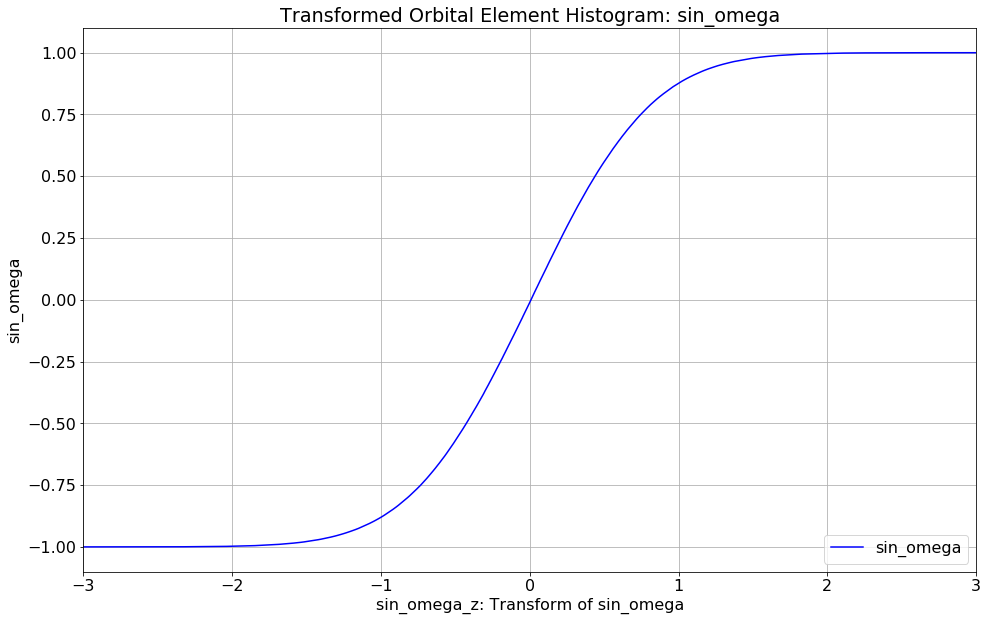

In [19]:
# Plot map of sin_omega
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_omega')

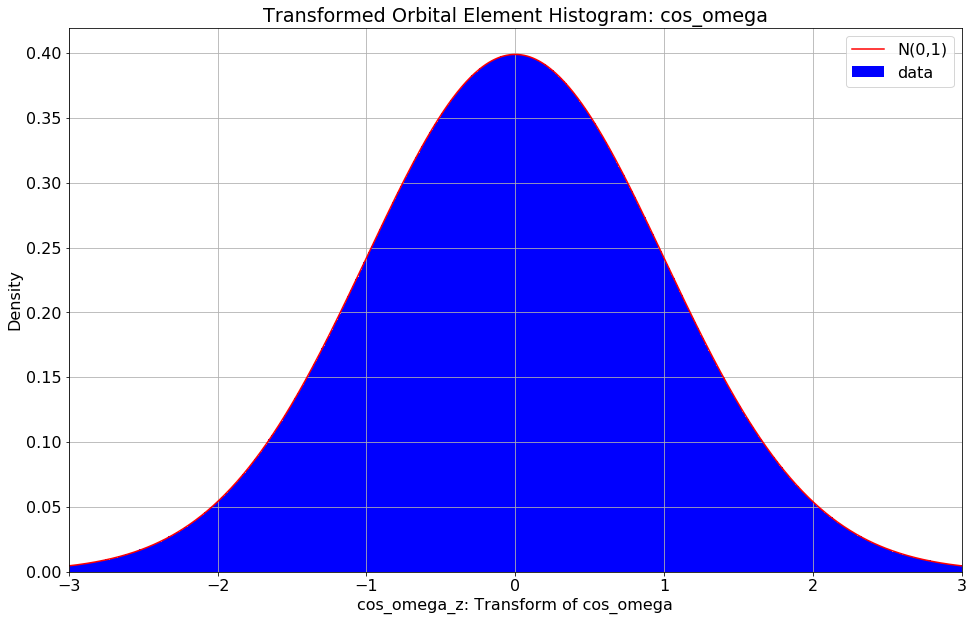

In [20]:
# Plot PDF of cos_omega
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_omega')

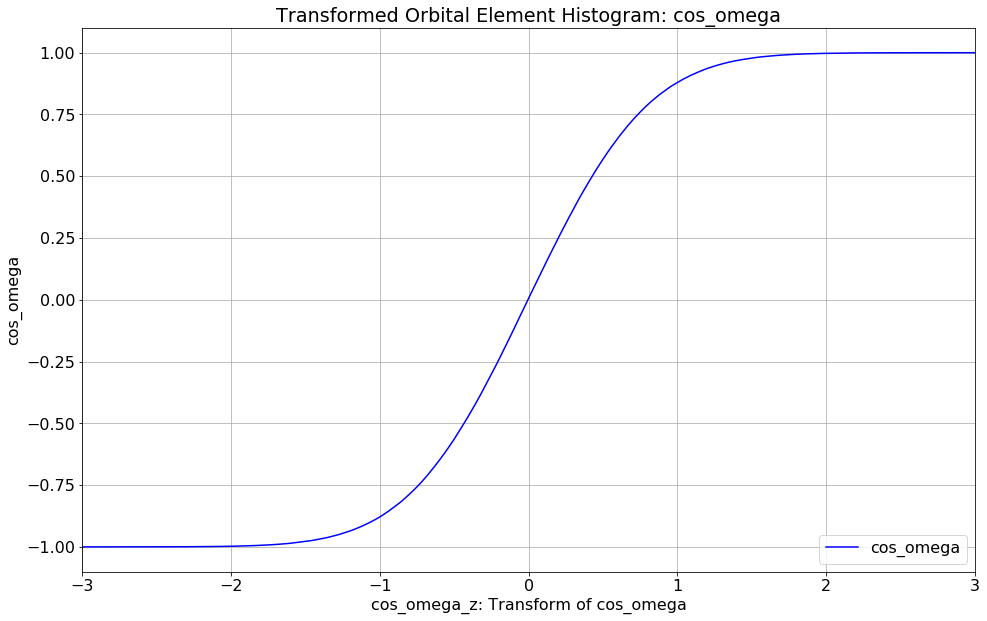

In [21]:
# Plot PDF of sin_Omega
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='cos_omega')

## True Anomaly, f

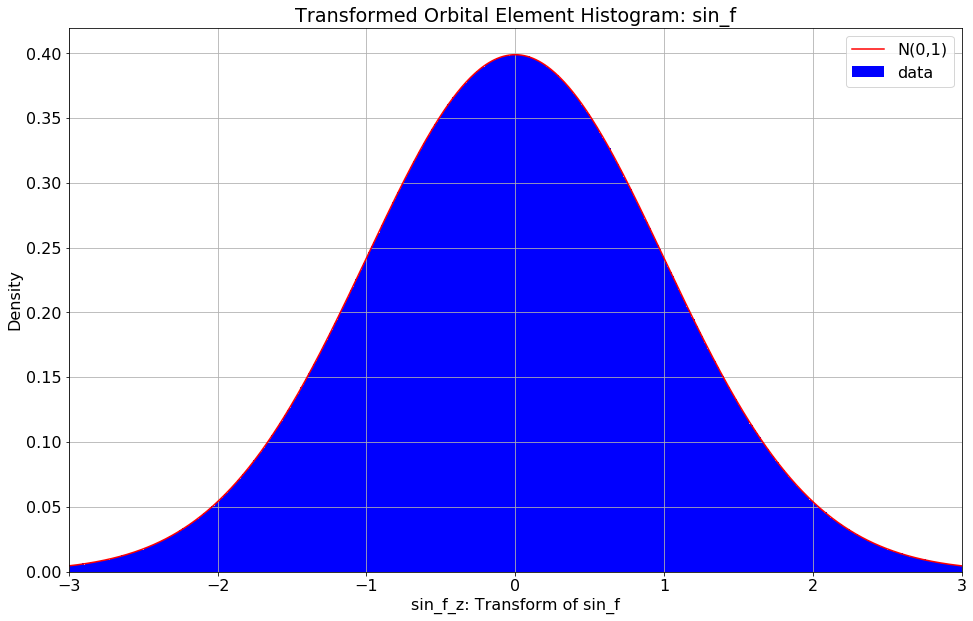

In [22]:
# Plot PDF of sin_f
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='sin_f')

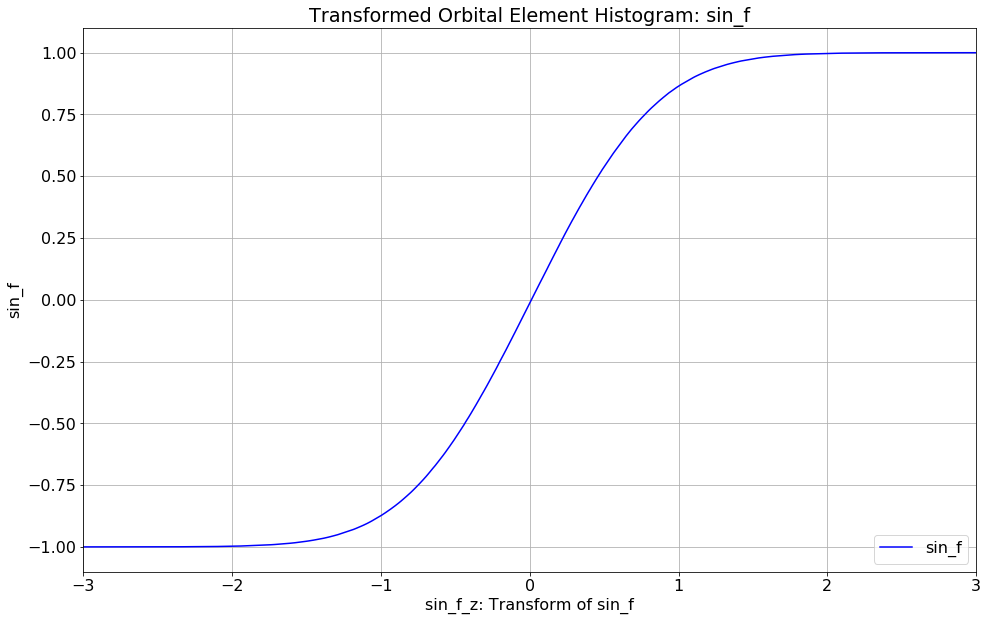

In [23]:
# Plot map of sin_omega
plot_elt_transform_map(ast_elt_xf=ast_elt_xf, elt_name='sin_f')

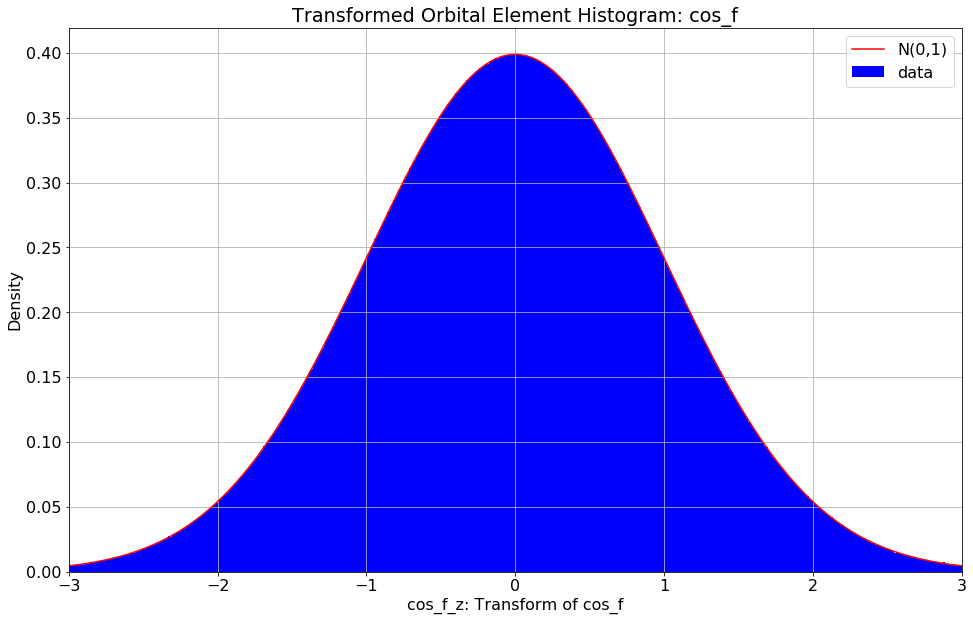

In [24]:
# Plot PDF of cos_f
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_f')

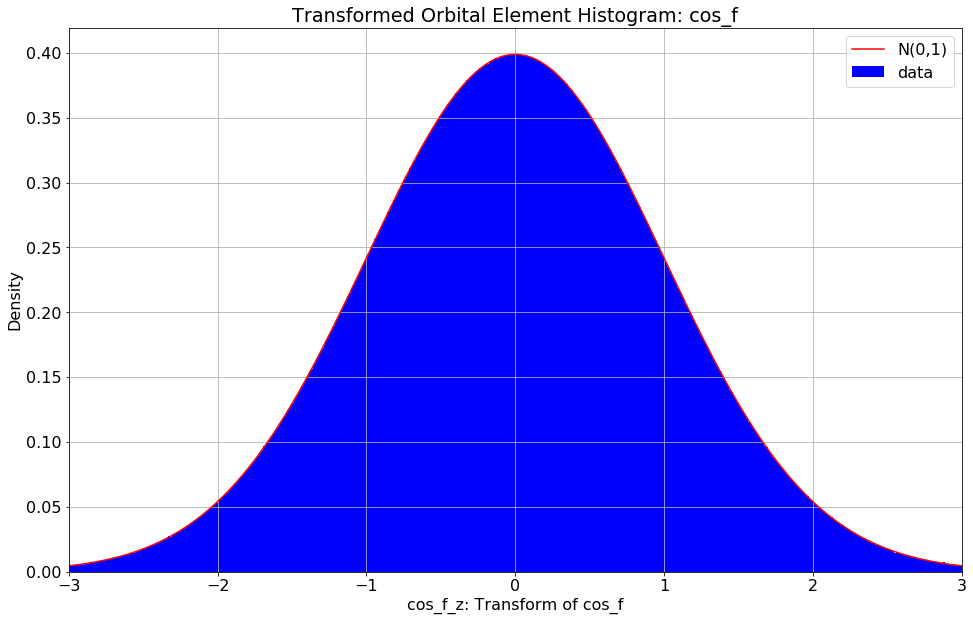

In [25]:
# Plot PDF of cos_f
plot_elt_transform_pdf(ast_elt_xf=ast_elt_xf, elt_name='cos_f')

## Covariance of Transformed Elements

In [26]:
# Build tranformation matrix beta and X_beta for computing distance to orbital elements
beta, X_beta = calc_beta(ast_elt_xf)

In [27]:
interp_tbl

{'log_a': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09050>,
 'e': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09950>,
 'sin_inc': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09a10>,
 'sin_Omega': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09a70>,
 'cos_Omega': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09b30>,
 'sin_omega': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09bf0>,
 'cos_omega': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09cb0>,
 'sin_f': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09d70>,
 'cos_f': <scipy.interpolate._cubic.PchipInterpolator at 0x7f2dc4d09e30>}

In [29]:
elt = ast_elt.iloc[0:10].copy()
elt

,Num,Name,epoch_mjd,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri
Num,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481
6,6,Hebe,58600.0,2.425160,0.203007,0.257225,2.419728,4.185430,1.504438,5.71,0.24,JPL 86,1.905453,1379.459713,0.004555,1.826410,2.227425,0.321973,-330.296006
7,7,Iris,58600.0,2.385334,0.231206,0.096406,4.530233,2.535354,2.450785,5.51,0.15,JPL 109,-3.593901,1345.619184,0.004669,3.233187,-2.811498,0.782402,-524.864951
8,8,Flora,58600.0,2.201764,0.156499,0.102747,1.935384,4.979205,3.401348,6.49,0.28,JPL 117,3.333848,1193.313725,0.005265,-2.250433,3.965252,0.631404,547.323632
9,9,Metis,58600.0,2.385637,0.123114,0.097334,1.202682,0.112004,4.832147,6.28,0.17,JPL 114,-1.697553,1345.875332,0.004668,-0.136353,-0.382867,1.314686,310.816364


In [35]:
# Copy index only of elt
elt_xf = elt.iloc[:, 0:0].copy()

# Add transformed values of input elements
elt_xf['log_a'] = np.log(elt.a)
elt_xf['e'] = elt.e
elt_xf['sin_inc'] = np.sin(elt.inc)
elt_xf['sin_Omega'] = np.sin(elt.Omega)
elt_xf['cos_Omega'] = np.cos(elt.Omega)
elt_xf['sin_omega'] = np.sin(elt.omega)
elt_xf['cos_omega'] = np.cos(elt.omega)
elt_xf['sin_f'] = np.sin(elt.f)
elt_xf['cos_f'] = np.cos(elt.f)

# Transform to normally distributed Z
elt_xf['log_a_z'] = interp_tbl['log_a'](elt_xf.log_a)
elt_xf['e_z'] = interp_tbl['e'](elt_xf.e)
elt_xf['sin_inc_z'] = interp_tbl['sin_inc'](elt_xf.sin_inc)
elt_xf['sin_Omega_z'] = interp_tbl['sin_Omega'](elt_xf.sin_Omega)
elt_xf['cos_Omega_z'] = interp_tbl['cos_Omega'](elt_xf.cos_Omega)
elt_xf['sin_omega_z'] = interp_tbl['sin_omega'](elt_xf.sin_omega)
elt_xf['cos_omega_z'] = interp_tbl['cos_omega'](elt_xf.cos_omega)
elt_xf['sin_f_z'] = interp_tbl['sin_f'](elt_xf.sin_f)
elt_xf['cos_f_z'] = interp_tbl['cos_f'](elt_xf.cos_f)

# Relevant columns
cols_xf = ['log_a_z', 'e_z', 'sin_inc_z', 'sin_Omega_z', 'cos_Omega_z', 'sin_omega_z', 'cos_omega_z', 'sin_f_z', 'cos_f_z',]
# Nx9 matrix of transformed elements
Y = elt_xf[cols_xf].values
# Scale columns 3:9 by sqrt(1/2) so they are not weighted 2x (need to represent them as sin, cos pair but don't want to overweight them)
Y[:, 3:9] *= np.sqrt(0.5)

# Multiply by beta
Y_beta = np.dot(Y, beta)

# Distance from Y to 
dist = np.linalg.norm(X_beta.reshape(-1, 1, 9) - Y_beta.reshape(1, -1, 9), axis=-1)

# Row number of nearest asteroid elements
idx = np.argmin(dist, axis=0)

# The closest asteroid elements
ast_elt.iloc[idx]

In [31]:
dist.shape

(733489, 10)

In [32]:
dist[0,0]

0.0

In [33]:
np.argmin(dist, axis=0)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
dist[0, 0:10]

In [ ]:
cols_xf = ['log_a_z', 'e_z', 'sin_inc_z', 'sin_Omega_z', 'cos_Omega_z', 'sin_omega_z', 'cos_omega_z', 'sin_f_z', 'cos_f_z',]

In [ ]:
elt_xf.loc[1:5, cols_xf]

In [ ]:
ast_elt_xf.loc[1:5, cols_xf]

In [ ]:
np.round(Y[0:5, :], 2)

In [ ]:
np.round(X[0:5, :], 2)

In [ ]:
np.round(Y_beta[0:5, :], 2)

In [ ]:
np.round(X_beta[0:5, :], 2)

In [ ]:
np.subtract(X_beta, Y_beta[0,:])

In [ ]:
X_beta.reshape(-1, 1, 9).shape

In [ ]:
Y_beta.reshape(1, -1, 9).shape

In [ ]:
v = np.linalg.norm(X_beta.reshape(-1, 1, 9) - Y_beta.reshape(1, -1, 9), axis=-1)

In [ ]:
v.shape

In [ ]:
np.round(v[0:5, 0:5], 2)

In [ ]:
# Relevant columns
cols_xf = ['log_a_z', 'e_z', 'sin_inc_z', 'sin_Omega_z', 'cos_Omega_z', 'sin_omega_z', 'cos_omega_z', 'sin_f_z', 'cos_f_z',]
# Nx9 matrix of transformed elements
Y = elt_test_xf[cols_xf].values
# Scale columns 3:9 by sqrt(1/2) so they are not weighted 2x (need to represent them as sin, cos pair but don't want to overweight them)
Y[:, 3:9] *= np.sqrt(0.5)
# Multiply by beta
Y_beta = np.dot(Y, beta)

In [ ]:
Y.shape

In [ ]:
X_beta.shape

In [ ]:
Y_beta.shape

In [ ]:
np.dot(Y_beta, X_beta.T).shape

In [36]:
ast_elt.iloc[idx]

,Num,Name,epoch_mjd,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri
Num,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481
6,6,Hebe,58600.0,2.425160,0.203007,0.257225,2.419728,4.185430,1.504438,5.71,0.24,JPL 86,1.905453,1379.459713,0.004555,1.826410,2.227425,0.321973,-330.296006
7,7,Iris,58600.0,2.385334,0.231206,0.096406,4.530233,2.535354,2.450785,5.51,0.15,JPL 109,-3.593901,1345.619184,0.004669,3.233187,-2.811498,0.782402,-524.864951
8,8,Flora,58600.0,2.201764,0.156499,0.102747,1.935384,4.979205,3.401348,6.49,0.28,JPL 117,3.333848,1193.313725,0.005265,-2.250433,3.965252,0.631404,547.323632
9,9,Metis,58600.0,2.385637,0.123114,0.097334,1.202682,0.112004,4.832147,6.28,0.17,JPL 114,-1.697553,1345.875332,0.004668,-0.136353,-0.382867,1.314686,310.816364
